In [78]:
import numpy as np
import scipy
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import warnings
from cycler import cycler

In [63]:
matplotlib.rcParams['figure.figsize'] = (18.0, 14.0)
matplotlib.style.use('ggplot')

In [64]:
def mejor_ajuste(data, bins, ax = None):
    
    #Crear modelos a partir de los datos
    y, x = np.histogram(data, bins = bins, density = True)
    x = (x + np.roll(x, -1))[:-1]/2.0
    
    #Distriibuciones a probar
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    mejor_distribucion = st.norm
    mejor_parametro = (0.0, 1.0)
    mejor_residual_cuadrado = np.inf
    
    #estimar la distribución de los datos
    for d in DISTRIBUTIONS:
        print(d)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                parametros = d.fit(data)
                
                arg = parametros[:-2]
                loc = parametros[-2]
                scale = parametros[-1]
                
                pdf = d.pdf(x, loc = loc, scale = scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax = ax)
                    end
                except Exception:
                    pass
                if mejor_residual_cuadrado > sse > 0:
                    mejor_distribucion = d
                    mejor_parametro = parametros
                    mejor_residual_cuadrado = sse
        except Exception:
            pass
    return (mejor_distribucion.name, mejor_parametro)

In [65]:
def make_pdf(dist, params, size=10000):
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [66]:
data = pd.read_csv("chisp.csv", sep = ',', encoding  = 'utf8')

In [67]:
data

,V1,V2,V3,V4,V5
0,9,11,15,17,19
1,7,9,15,16,22
2,2,6,7,8,10
3,1,4,10,15,25
4,6,13,19,24,26
...,...,...,...,...,...
98275,2,5,12,15,19
98276,4,5,9,12,27
98277,2,10,13,19,25
98278,2,4,16,17,19


<Figure size 864x576 with 0 Axes>

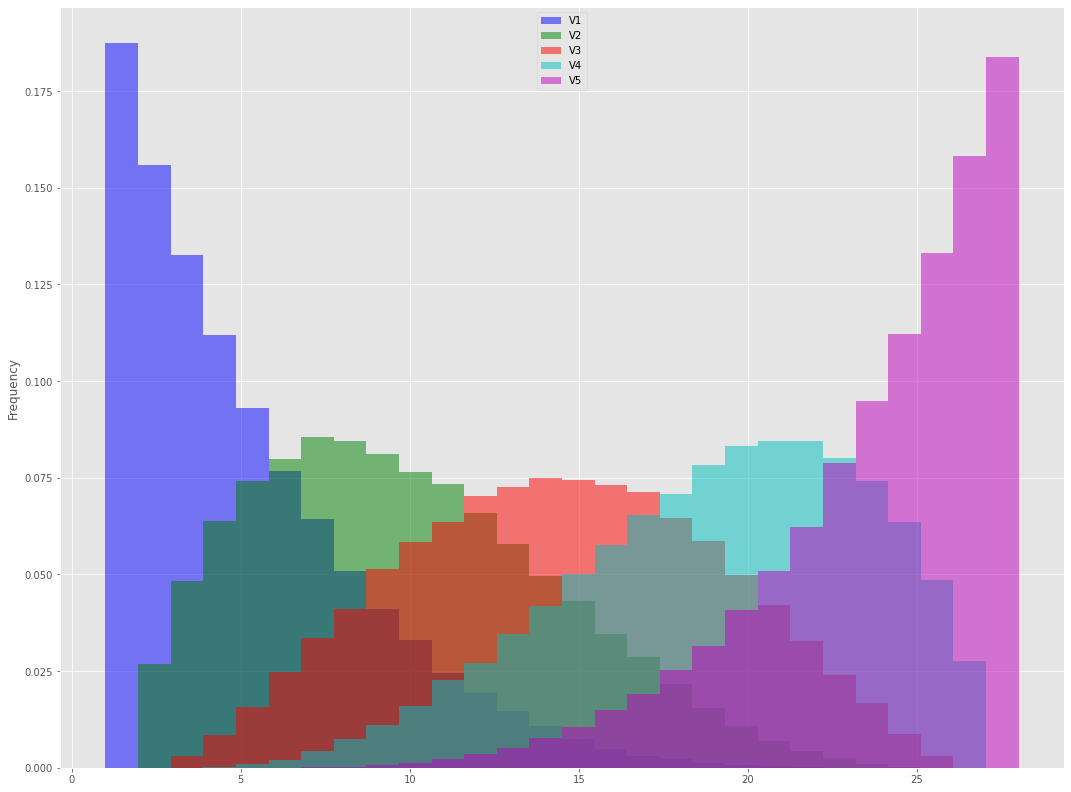

In [69]:
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=28, density = True, alpha=0.5, color = 'bgrcmyk' )
data_ylim = ax.get_ylim

In [56]:
dataYLim = ax.get_ylim()

In [70]:
best_fit_name, best_fit_params = mejor_ajuste(data, 28, ax)
best_dist = getattr(st, best_fit_name)

In [71]:
best_fit_name

'uniform'

In [72]:
best_fit_params

(1.0, 27.0)

In [73]:
ax.set_ylim(dataYLim)
ax.set_title(u'Chispazo, todas las distribuciones ajustadas')
ax.set_xlabel('Número')
ax.set_ylabel('Frecuencia')

Text(20.200000000000017, 0.5, 'Frecuencia')

In [74]:
pdf = make_pdf(best_dist, best_fit_params)

Text(0, 0.5, 'Frecuencia')

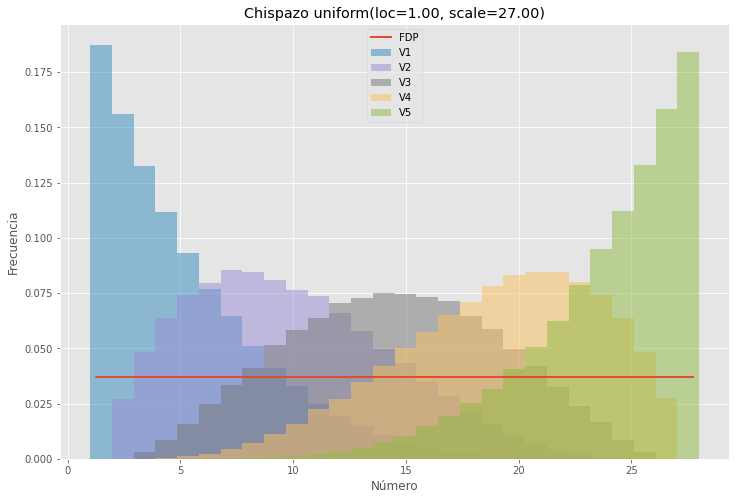

In [76]:
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='FDP', legend=True)
data.plot(kind='hist', bins=28, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Chispazo ' + dist_str)
ax.set_xlabel(u'Número')
ax.set_ylabel('Frecuencia')

<ipython-input-86-03b464084027>:3: DeprecationWarning: scipy.round_ is deprecated and will be removed in SciPy 2.0.0, use numpy.round_ instead
  y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
/home/spqr14/Desarrollo/datascience/lib64/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/spqr14/Desarrollo/datascience/lib64/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


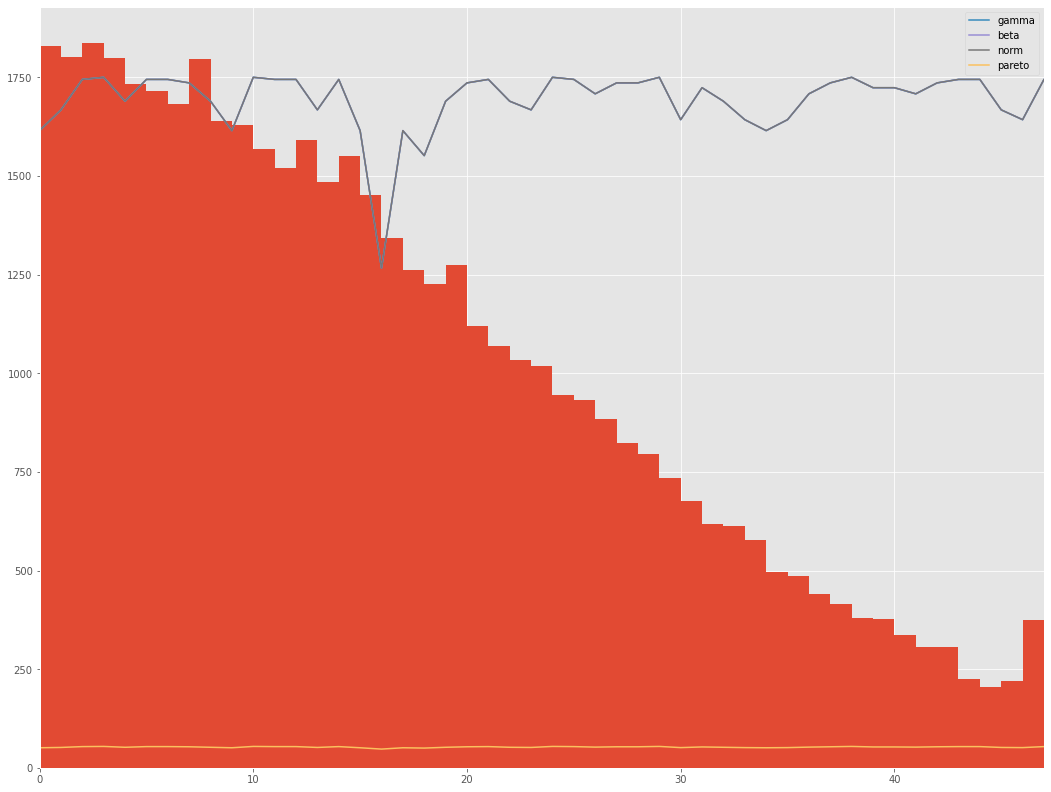

In [86]:
size = 98280
x = data['V1']
y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
h = plt.hist(y, bins=range(48))

dist_names = ['gamma', 'beta', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

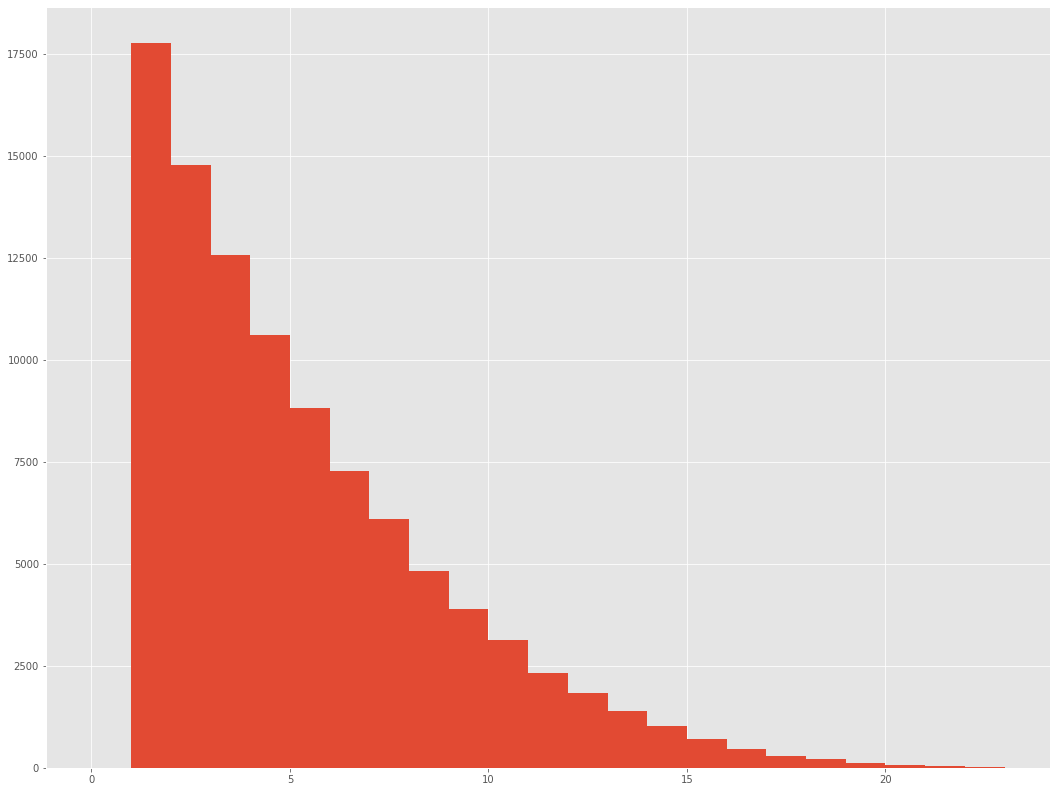

In [113]:
y = data['V1']
h = plt.hist(y, bins = range(max(y)))


In [112]:
max(data['V1'])

24